In [16]:
import sys

import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSIncome
import matplotlib.pyplot as plt
from itertools import product

from lib.recursive_stopping import RecursiveStoppingRule
from lib.repair import RecursiveStoppingRepair

from lib.utils import load_ACS_income, preprocess_ACS_data, repair_year_state, representation_bias_report
from lib.evals import eval_damage, eval_report

from pprint import pprint

In [17]:
year, state = 2014, 'TX'
u_feat, u_thresh = 'SCHL', 16
s_feat, s_thresh = 'RAC1P', 1

epsilon = 4e-3
v_init = 1e-4
forgetting_factor = 0.1

In [18]:
data, labels = load_ACS_income(year, state)
data = preprocess_ACS_data(data, u=u_feat, u_thresh=u_thresh, s=s_feat, s_thresh=s_thresh).sample(frac=1) # shuffle incoming data

print(f'Total respondents: {len(data)}')

representation_bias_report(data)

Total respondents: 127039
u  s
1  1    0.688206
   0    0.184802
0  1    0.095231
   0    0.031762
Name: count, dtype: float64


In [19]:
N_bar = 50000
l = 0.1

features = data.drop(columns=['u','s','SEX','RAC1P'], errors='ignore').columns

rules = {feat: {u: {s: RecursiveStoppingRule(N_bar=N_bar, x_min=-10000, x_max=10000, epsilon=epsilon, v_init=v_init) for s in data['s'].unique()}
                for u in data['u'].unique()}
        for feat in features}

# pprint(rules)

In [20]:
for i, row in data.iterrows():
        
    for f in features:
        # increment each stopping rule separately
        if rules[f][row['u']][row['s']].curr_rule.finished:
            continue
        else:
            rules[f][row['u']][row['s']].sample(row[f])

# rules[feat][u][s].increment_t(l)

In [21]:
# test if all rules finished
stopping_nums = {f: {u: {s: int(rules[f][u][s].curr_rule.v) for s in data['s'].unique()} for u in data['u'].unique()} for f in features}

for f in features:
    for u in data['u'].unique():
        for s in data['s'].unique():
            if not rules[f][u][s].curr_rule.finished:
                print(f'{f}, ({u},{s}) did not finish.')
            
pprint(stopping_nums)

AGEP, (0,0) did not finish.
COW, (0,0) did not finish.
MAR, (0,0) did not finish.
OCCP, (0,0) did not finish.
POBP, (0,0) did not finish.
RELP, (0,0) did not finish.
WKHP, (0,0) did not finish.
{'AGEP': {0: {0: 4035, 1: 6118}, 1: {0: 6134, 1: 6141}},
 'COW': {0: {0: 4035, 1: 5667}, 1: {0: 5796, 1: 5830}},
 'MAR': {0: {0: 4035, 1: 4655}, 1: {0: 4463, 1: 4840}},
 'OCCP': {0: {0: 4035, 1: 4723}, 1: {0: 4865, 1: 4833}},
 'POBP': {0: {0: 4035, 1: 4904}, 1: {0: 5219, 1: 5250}},
 'RELP': {0: {0: 4035, 1: 5761}, 1: {0: 5612, 1: 5610}},
 'WKHP': {0: {0: 4035, 1: 5438}, 1: {0: 5469, 1: 5451}}}


In [22]:
stopping_rb = pd.DataFrame.from_dict({u: {s: int(rules[f][u][s].curr_rule.v) for s in data['s'].unique()} for u in data['u'].unique()}, orient='index').stack()
stopping_rb / stopping_rb.sum()

0  1    0.266660
   0    0.197862
1  1    0.267298
   0    0.268180
dtype: float64

In [23]:
reports = []
repaired_df = pd.DataFrame()

for f in features:

    repair = RecursiveStoppingRepair(rules=rules[f])
    repaired_data = repair.repair_data(data[[f, 'u', 's']])

    report = eval_report(data[[f, 'u', 's']], repaired_data, n=50, method='TV')
    repaired_df[[f, 'u', 's']] = repaired_data

    reports.append(
        pd.DataFrame.from_dict({(i,j): report[i][j] 
                            for i in report.keys() 
                            for j in report[i].keys()},
                            orient='index'
                       )
    )
    reports[-1] = reports[-1].add_prefix('U = ')

    reports[-1].loc[(f, 'n'), ['U = 0','U = 1']] = [np.floor(rules[f][0][0].curr_rule.v) + np.floor(rules[f][0][1].curr_rule.v),
                                                    np.floor(rules[f][1][0].curr_rule.v) + np.floor(rules[f][1][1].curr_rule.v)]


In [24]:
report = pd.concat(reports)
report

U = 0         U = 1
AGEP damage                   0.098407      0.089247
     invariance               0.015675      0.023286
     original_invariance      0.036955      0.065654
     n                    10153.000000  12275.000000
COW  damage                   0.426951      1.252421
     invariance               0.072826      0.072182
     original_invariance      0.161219      0.392849
     n                     9702.000000  11626.000000
MAR  damage                   1.586965      2.469086
     invariance               0.085053      0.171736
     original_invariance      0.471475      1.458416
     n                     8690.000000   9303.000000
OCCP damage                   0.000642      0.000999
     invariance               0.000144      0.000242
     original_invariance      0.000471      0.000668
     n                     8758.000000   9698.000000
POBP damage                   0.014379      0.025019
     invariance               0.001196      0.002096
     original_invariance      0.015865      0.020307
     n                     8939.000000  10469.000000
RELP damage                   0.421106      0.526670
     invariance               0.063237      0.045539
     original_invariance      0.153295      0.194914
     n                     9796.000000  11222.000000
WKHP damage                   0.023554      0.085433
     invariance               0.010913      0.012729
     original_invariance      0.018483      0.045382
     n                     9473.000000  10920.000000

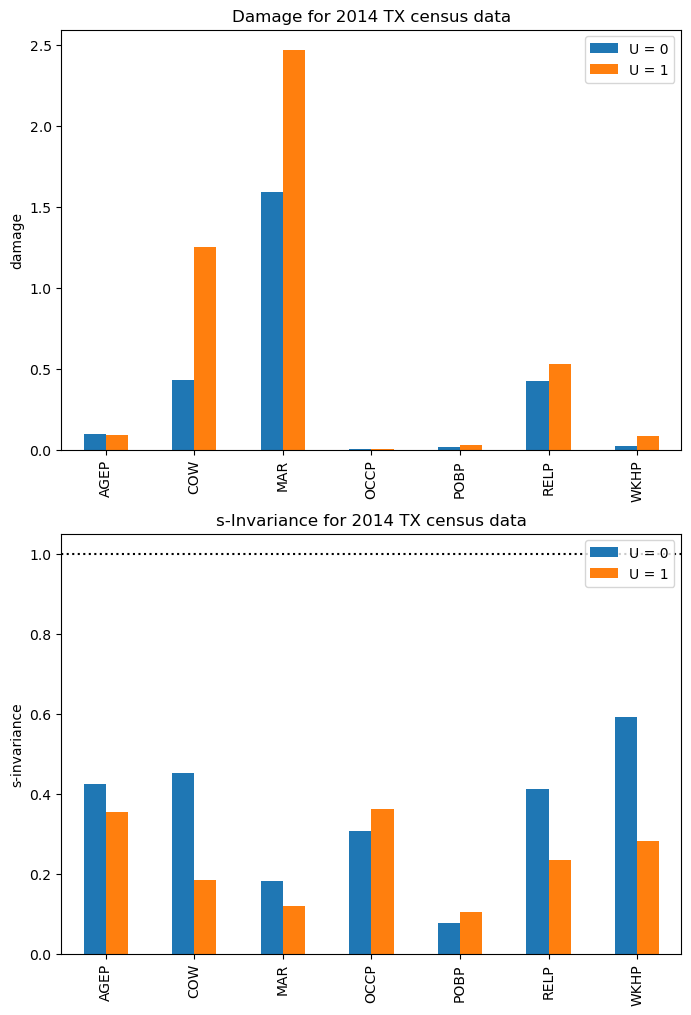

In [25]:
fig, axs = plt.subplots(2,1, figsize=(8,12))

# Data damage
report.iloc[::4,:2].plot.bar(ax=axs[0])

axs[0].set_xticklabels(report.index.get_level_values(0)[::4])

axs[0].set_title(f'Damage for {year} {state} census data')
axs[0].set_ylabel(f'damage')


# s-invariance
# report.iloc[1::4,:2].plot.bar(ax=axs[1]) # invariance
(report.iloc[1::4] / report.iloc[2::4].values).plot.bar(ax=axs[1]) # scaled invariance
axs[1].hlines(y=1, xmin=-1, xmax=7, colors='k', linestyles='dotted')

axs[1].set_xticklabels(report.index.get_level_values(0)[1::4])

axs[1].set_title(f's-Invariance for {year} {state} census data')
axs[1].set_ylabel(f's-invariance')

# axs[1].set_ylim((0,5))

fig.savefig(f'results/initial_forgetting_tests/{year}-{state}_{u_feat}-{int(u_thresh)}_{s_feat}-{int(s_thresh)}_{epsilon}-{v_init}-{forgetting_factor}.png', bbox_inches='tight')

In [26]:
report.to_csv(f'results/initial_forgetting_tests/{year}-{state}_{u_feat}-{int(u_thresh)}_{s_feat}-{int(s_thresh)}_{epsilon}-{v_init}-{forgetting_factor}.csv')

TO DO:
 - ~~Conduct repair based on stopping numbers~~
 - ~~Compile repaired on-sample and off-sample data~~
 - ~~Produce eval report for the compiled data~~
 - ~~PPrint eval report~~
 - ~~Plot results~~
 - Group code into class
 - Test on 2014 - 2023 ACSIncome data
 - ~~Util function to report representation bias~~
 - ~~Util function to compare stopping data to data distributions -- test ideal stopping params~~
 - Test on |U| > 2 -- split by education class??
***
 - Test Wasserstein s-Invariance and damage metrics -- cope with non-shared support??
 - Fix StoppingRepair code -- write a test to plot hists before/after repair? What could be breaking in the repair logic?

## Visual verification of fairness correction 

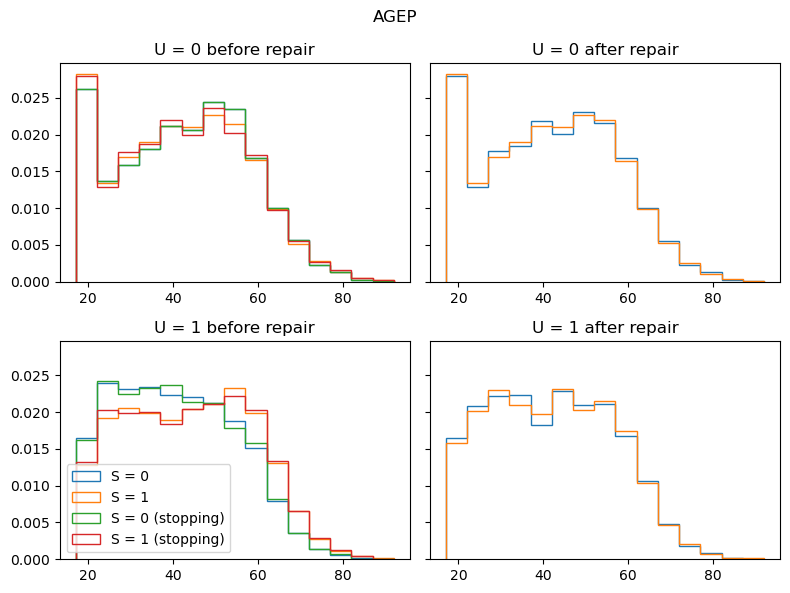

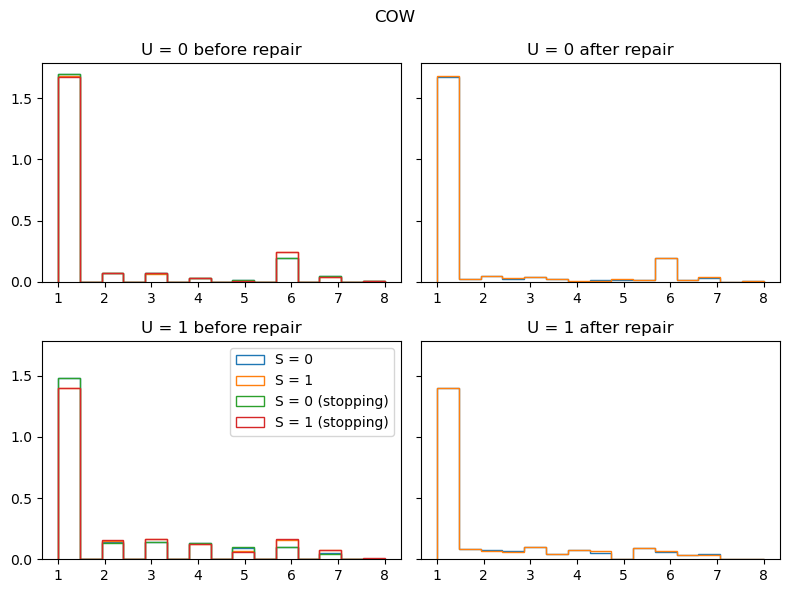

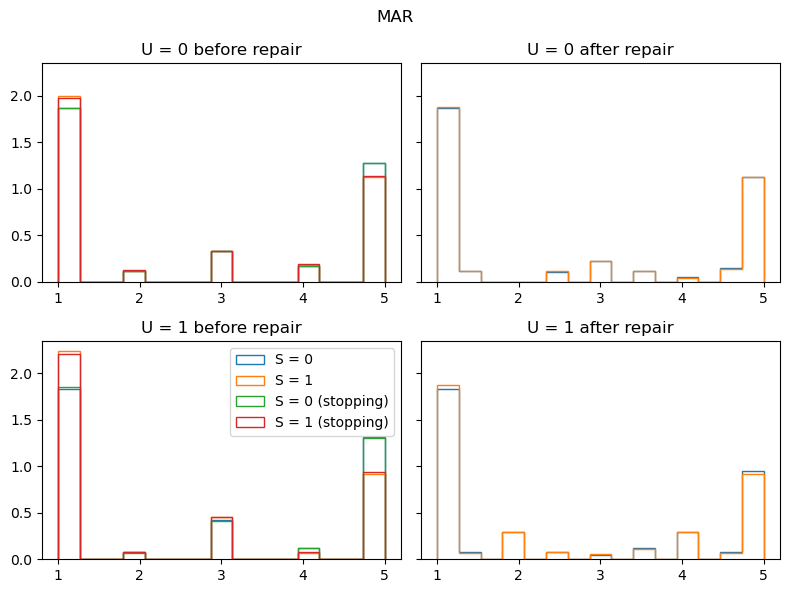

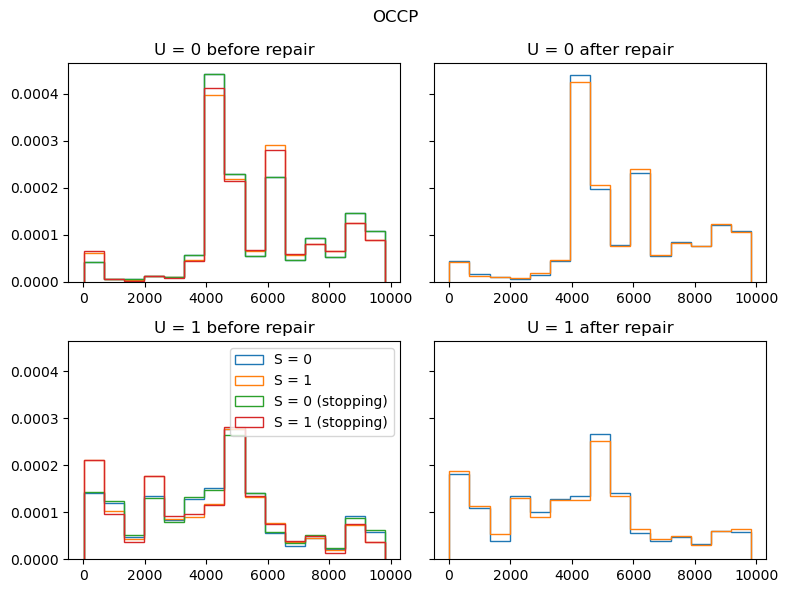

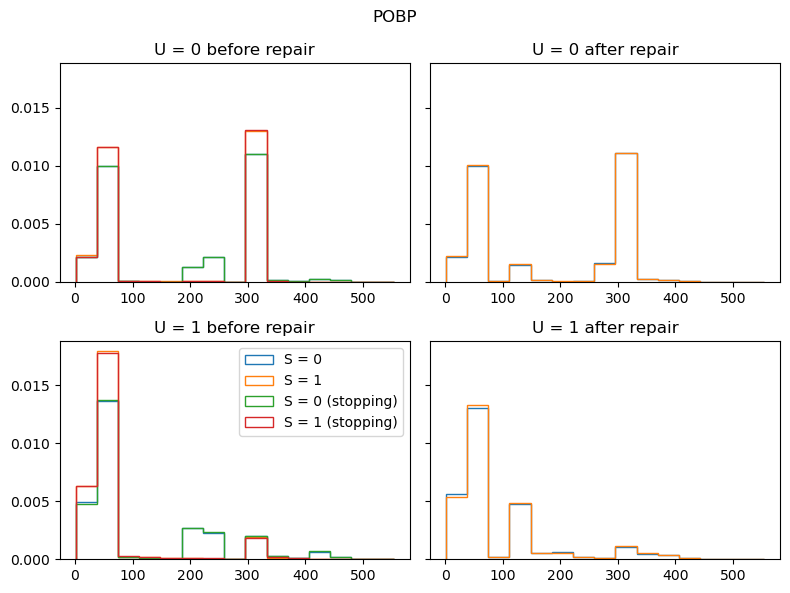

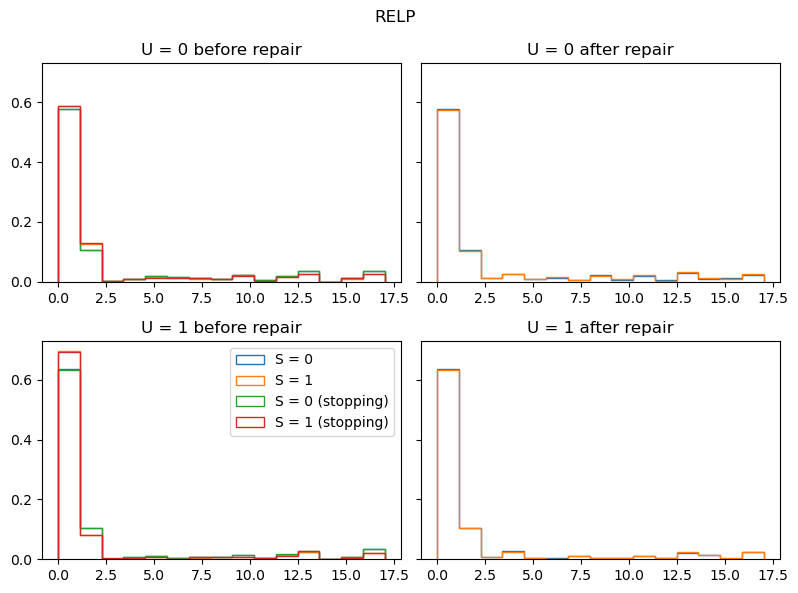

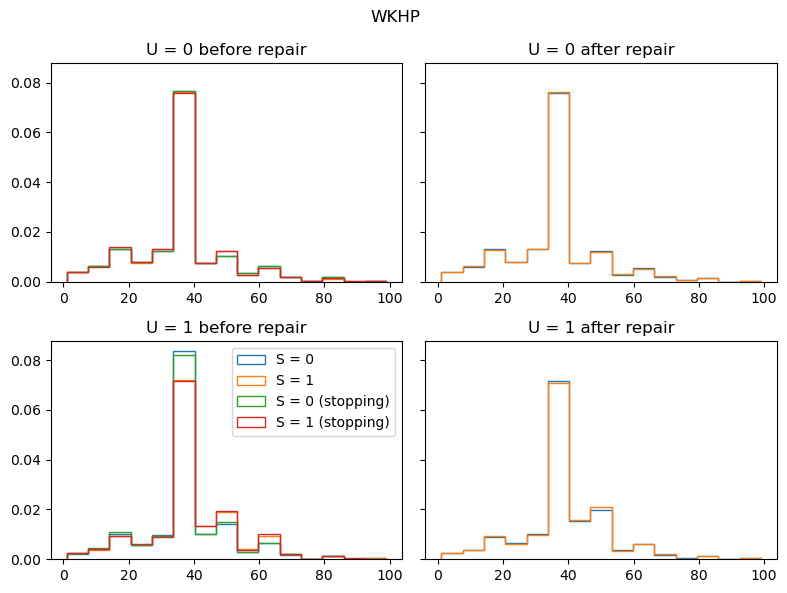

In [27]:
for f in features:

    fig, axs = plt.subplots(2, 2, figsize=(8,6), sharey=True)
    fig.suptitle(f)

    bins = np.histogram(data[f], bins=15)[1]

    for i, u in enumerate([0,1]):

        axs[i,0].hist(data[(data['u'] == u) & (data['s'] == 0)][f], bins=bins, histtype='step', density=True, label=f'S = {0}')
        axs[i,0].hist(data[(data['u'] == u) & (data['s'] == 1)][f], bins=bins, histtype='step', density=True, label=f'S = {1}')

        axs[i,0].hist(np.repeat(rules[f][u][0].curr_rule.verts, rules[f][u][0].curr_rule.verts_weights)[1:-1], bins=bins, histtype='step', density=True, label=f'S = {0} (stopping)')
        axs[i,0].hist(np.repeat(rules[f][u][1].curr_rule.verts, rules[f][u][1].curr_rule.verts_weights)[1:-1], bins=bins, histtype='step', density=True, label=f'S = {1} (stopping)')

        axs[i,1].hist(repaired_df[(repaired_df['u'] == u) & (repaired_df['s'] == 0)][f], bins=bins, histtype='step', density=True, label=f'S = {0}')
        axs[i,1].hist(repaired_df[(repaired_df['u'] == u) & (repaired_df['s'] == 1)][f], bins=bins, histtype='step', density=True, label=f'S = {1}')

        axs[i,0].set_title(f'U = {u} before repair')
        axs[i,1].set_title(f'U = {u} after repair')

    axs[i,0].legend()

    fig.tight_layout()

## Forgetting test

In [28]:
from tqdm import tqdm

In [29]:
for f in features:
    for u in data['u'].unique():
        for s in data['s'].unique():
            rules[f][u][s].increment_t(forgetting_factor)

In [30]:
for year in tqdm(np.arange(year+1, 2024)):
    if year == 2020: continue

    # load data
    data, labels = load_ACS_income(year, state)
    data = preprocess_ACS_data(data, u=u_feat, u_thresh=u_thresh, s=s_feat, s_thresh=s_thresh).sample(frac=1) # shuffle incoming data

    # stopping rules
    for i, row in data.iterrows():
        for f in features:
            # increment each stopping rule separately
            if rules[f][row['u']][row['s']].curr_rule.finished:
                continue
            else:
                rules[f][row['u']][row['s']].sample(row[f])

    # repair data
    reports = []
    repaired_df = pd.DataFrame()
    for f in features:

        repair = RecursiveStoppingRepair(rules=rules[f])
        repaired_data = repair.repair_data(data[[f, 'u', 's']])

        report = eval_report(data[[f, 'u', 's']], repaired_data, n=50, method='TV')
        repaired_df[[f, 'u', 's']] = repaired_data

        reports.append(
            pd.DataFrame.from_dict({(i,j): report[i][j] 
                                for i in report.keys() 
                                for j in report[i].keys()},
                                orient='index'
                        )
        )
        reports[-1] = reports[-1].add_prefix('U = ')

        reports[-1].loc[(f, 'n'), ['U = 0','U = 1']] = [np.floor(rules[f][0][0].curr_rule.v) + np.floor(rules[f][0][1].curr_rule.v),
                                                        np.floor(rules[f][1][0].curr_rule.v) + np.floor(rules[f][1][1].curr_rule.v)]
    
    report = pd.concat(reports)
    report.to_csv(f'results/initial_forgetting_tests/{year}-{state}_{u_feat}-{int(u_thresh)}_{s_feat}-{int(s_thresh)}_{epsilon}-{v_init}-{forgetting_factor}.csv')

    for f in features:
        for u in data['u'].unique():
            for s in data['s'].unique():
                rules[f][u][s].increment_t(forgetting_factor)


  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [01:00<08:00, 60.10s/it]

 22%|██▏       | 2/9 [01:59<06:58, 59.79s/it]

 56%|█████▌    | 5/9 [04:58<03:58, 59.60s/it]

 78%|███████▊  | 7/9 [06:07<01:33, 46.85s/it]

 89%|████████▉ | 8/9 [07:26<00:55, 55.45s/it]

100%|██████████| 9/9 [08:37<00:00, 57.46s/it]
